In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from bigfile import BigFile
import glob,os,struct
# from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from scipy.interpolate import interp1d
from colossus.cosmology import cosmology

import seaborn as sns

sns.set()
sns.set_palette("Set2")
sns.set_style('ticks',{'ytick.direction':'in','xtick.direction':'in'})

cmap = plt.get_cmap("Set2")
sns.set_context("paper", font_scale=1.7,rc={"axes.linewidth": 1.3,"lines.linewidth": 2.5,"patch.linewidth": 2.2})
from matplotlib import rcParams as rc
import pickle
import warnings
import h5py

In [3]:
snap = 214

outdir = '/hildafs/datasets/Asterix/PIG2/PIG_%03d_subfind'%snap
pig2 = BigFile(outdir)

# you can check the redshift by reading the attributes of the snapshot
battr = pig2["Header"].attrs
scale_fac = battr["Time"][0]
redshift = 1./battr["Time"][0] - 1
Lbox = battr['BoxSize']
hh = battr['HubbleParam']
om0 = battr['Omega0']
omb = battr['OmegaBaryon']
oml = battr['OmegaLambda']
Nfof = battr['NumFOFGroupsTotal']
sigma8 = 0.82
print('----------PIG file info------------')

print('Redshift = %.2f'%redshift)
print('Lbox = %d ckpc/h'%Lbox)
print('NfofGroups = %d'%Nfof)

print('------cosmological parameters-----')
print('h = %.4f'%hh)
print('Omega_m = %.4f'%om0)
print('Omega_b = %.4f'%omb)
print('Omega_l = %.4f'%oml)

----------PIG file info------------
Redshift = 3.00
Lbox = 250000 ckpc/h
NfofGroups = 193500739
------cosmological parameters-----
h = 0.6774
Omega_m = 0.3089
Omega_b = 0.0486
Omega_l = 0.6911


### Subfind Summary

In [20]:
gLength = pig2['FOFGroups/LengthByType']
gOffset = pig2['FOFGroups/OffsetByType']
FirstSub = pig2['FOFGroups/GroupFirstSub']

sLength = pig2['SubGroups/SubhaloLenType']
sOffset = pig2['SubGroups/SubhaloOffsetType']
sMass = pig2['SubGroups/SubhaloMassType']

NSubs = pig2['FOFGroups/GroupNsubs']

In [24]:
nsubs_all = NSubs[:]

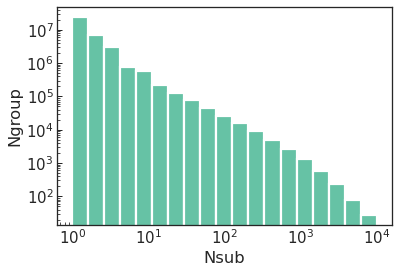

In [27]:
plt.hist(nsubs_all, bins = np.logspace(0, 4, 20))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Nsub')
plt.ylabel('Ngroup')

plt.show()

### check BH offset

In [28]:
BHMass = pig2['5/BlackholeMass'][:]*1e10/hh
bidxlist, = np.where(BHMass > 5e5)

bmass = BHMass[bidxlist]
del BHMass
print(len(bidxlist))

894110


In [29]:
suboff = pig2['SubGroups/SubhaloOffsetType'][:]
suboff5 = suboff[:,5]
del suboff

In [30]:
def place(bidxlist,suboff5):
    sidxlist = np.searchsorted(suboff5,bidx,side='right')-1
    return sidxlist

def get_offset(bidxlist,sidxlist):
    centers = pig2['SubGroups/SubhaloPos'][:][sidxlist]
    dpos = pig2['5/Position'][:][bidxlist] - centers
    dpos[dpos > box/2] -= box
    dpos[dpos < -box/2] += box
    return np.linalg.norm(dpos,axis=1)

In [31]:
box = 250000.
sidxlist = np.searchsorted(suboff5,bidxlist,side='right')-1
print('got sidx')
roff = get_offset(bidxlist,sidxlist)

got sidx


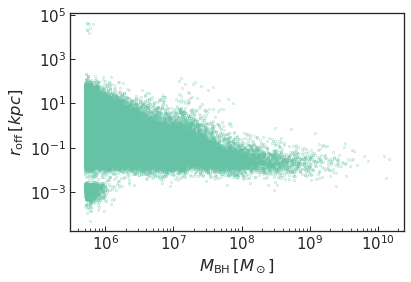

In [32]:
plt.scatter(bmass,roff/4,s=0.1)
plt.xscale('log')
plt.xlabel(r'$M_{\rm BH}\,[M_\odot]$')
plt.ylabel(r'$r_{\rm off}\,[kpc]$')
plt.yscale('log')

#### check for a large offset to see if it is physical

963
72390
3193
[[121209094  23200624         0         0  25685819      3180]
 [122748546  25414783         0         0  28942721      3271]]
[[1539452 2214159       0       0 3256902      91]
 [  42688   53681       0       0  132083       8]]
[1539452 2214159       0       0 3256902      91]
[121209094  23200624         0         0  25685819      3180] [122748546  25414783         0         0  28942721      3271]


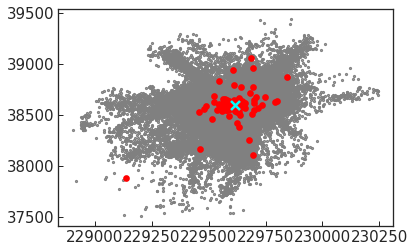

In [33]:
mask = roff > 100
blist = bidxlist[mask]
slist = sidxlist[mask]
print(len(blist))


sidx = slist[16]
print(sidx)
print(blist[16])

soff = pig2['SubGroups/SubhaloOffsetType'][sidx]
slen = pig2['SubGroups/SubhaloLenType'][sidx]


print(pig2['SubGroups/SubhaloOffsetType'][sidx:sidx+2])
print(pig2['SubGroups/SubhaloLenType'][sidx:sidx+2])
sbeg,send = soff, soff + slen
print(slen)
print(sbeg,send)
pos5 = pig2['5/Position'][sbeg[5]:send[5]]
pos4 = pig2['4/Position'][sbeg[4]:send[4]]
# pos1 = pig2['1/Position'][sbeg[1]:send[1]]


center = pig2['SubGroups/SubhaloPos'][sidx]

plt.scatter(pos4[:,0],pos4[:,1],s=1,color='grey')
# plt.scatter(pos1[:,0],pos1[:,1],s=1,color='grey')
plt.scatter(pos5[:,0],pos5[:,1],s=20,color='red')
plt.scatter(center[0],center[1],marker='x',color='cyan',s=80)
plt.show()